### Working With ASDF Files

#### Outline

- Read a file
- Show the contents of an ASDF file
- Search for an attribute in an ASDF file
- Accessing metadata and data
- Modifying and saving files
- Exercise
- Adding History items

#### Reading an ASDF file

The Python ASDF library is a standalone package distributed through PyPi and conda-forge.

In [1]:
import asdf

To open a file use the `open` function. It is useful to look up the keyword arguments it accepts, there are options specifying how a file should be opened or validated during opening. For this example we will use the default behavior and look at the object.

In [2]:
af = asdf.open('pluto.asdf')

2022-06-23 17:01:35,353 - stpipe - WARNING - /Users/dencheva/opt/anaconda3/envs/rb6/lib/python3.9/site-packages/asdf/asdf.py:348: AsdfWarning: File 'file:///Users/dencheva/dev/roman-data-workshop/03-Working_With_ASDF_Files/pluto.asdf' was created with extension class 'asdf.extension.BuiltinExtension' (from package asdf==2.12.0), but older package (asdf==2.11.2.dev13+gf9aeb247) is installed.
  warnings.warn(msg, AsdfWarning)



#### Getting information about a file

There are two functions that allow introspecting a file, `info` and `search`. They are available as methods on the `AsdfFile` object or on the command line. Both are configurable through multiple parameters.

In [3]:
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension.BuiltinExtension
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 2.12.0
│   └─[1] (ExtensionMetadata)
│     ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│     ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.5.0
│     └─software (Software)
│       ├─name (str): asdf-astropy
│       └─version (str): 0.2.1
├─birthday (date)
├─mass (Quantity): shape=(), dtype=float64
├─name (str): Pluto
└─picture (NDArrayType): shape=(333, 151, 4), dtype=float32


The asdf library has search capabilities. A file can be searched for an attribute by name, type or value.

In [4]:
af.search('birthday')

root (AsdfObject)
└─birthday (date)

In [5]:
af.search(value='Pluto')

root (AsdfObject)
└─name (str): Pluto

In [6]:
from astropy import units as u

af.search(type=u.Quantity)

root (AsdfObject)
└─mass (Quantity): shape=(), dtype=float64

#### Accessing and Modifying a file

In [7]:
weight = af['mass']
print(weight)

10.0 kg


And we can display the data directly with matplotlib.

In [8]:
from matplotlib import pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


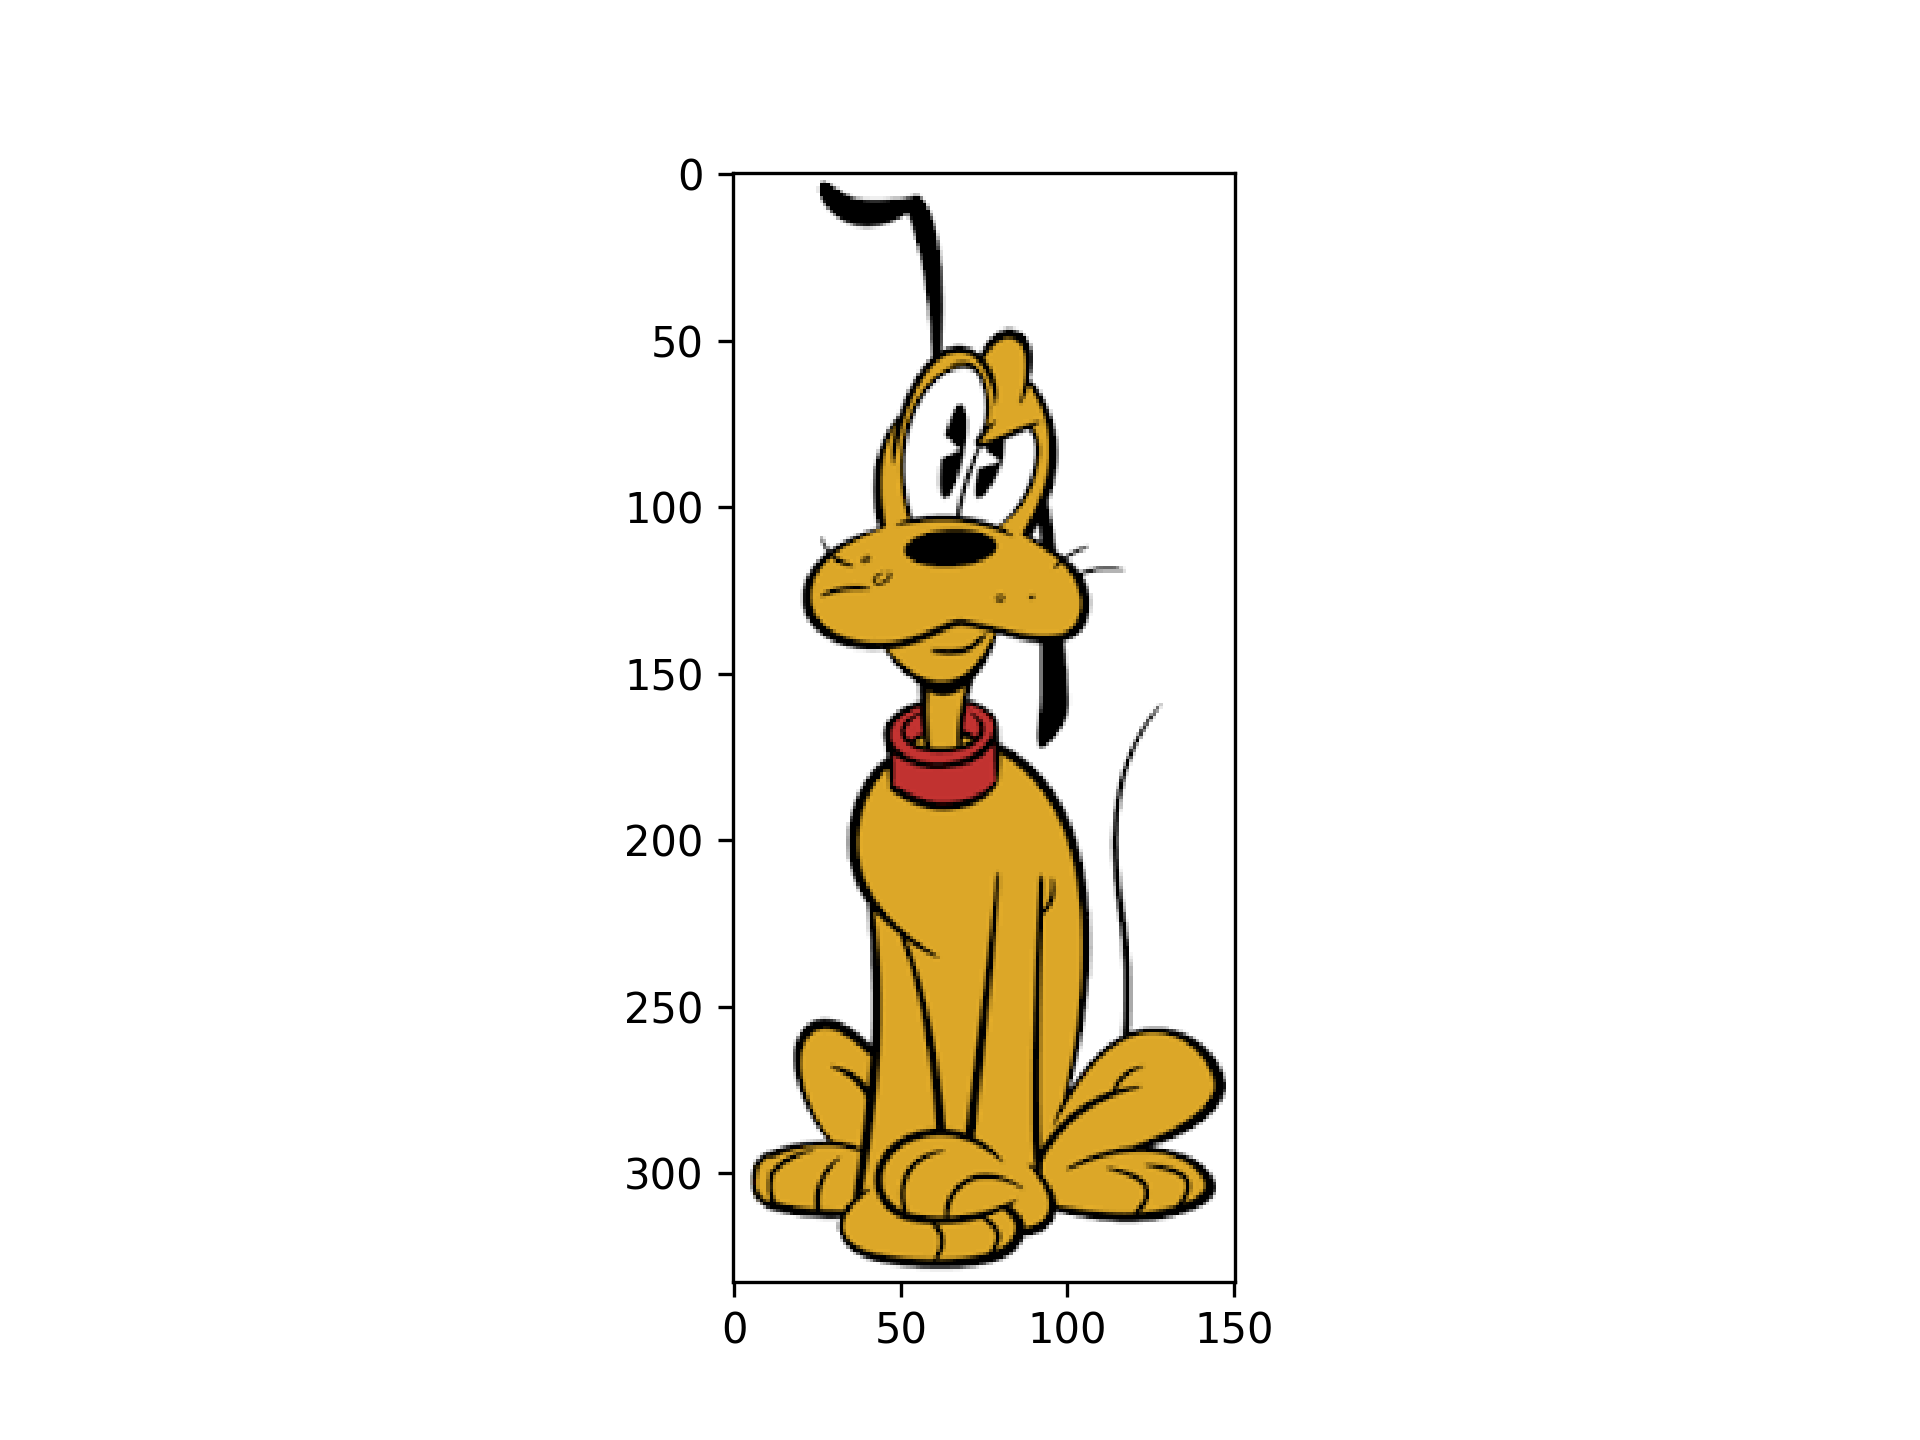

In [12]:
plt.imshow(af['picture'])

**Exercise 1:**

- Open the `cal` file in the data directory,  `../data/r0000101001001001001_01101_0001_WFI01_cal.asdf`. Look at the `info` method's help and   display the file using some of the arguments to show more contents.
- Search for the attribute `wcs`
- Retrieve the `wcs` object following the path showed by the `search` method
- print the `wcs` object and evaluate it on pixel (200, 300)
- Look at the `data` array and modify the value of `data[0, 0]`  to 999.

#### Using a schema to validate a file

ASDF uses schemas to check that a file conforms to the [ASDF Standard](https://asdf-standard.readthedocs.io/en/latest/) and possibly the requirements of other extensions (see later notebooks). `jsonschema` is used for validation. Schema validation happens on reading (`asdf.open`) and writing (`write_to` and `update`). 

However, sometimes it is useful for particular applications to impose additional restrictions when deciding whether a given file is valid or not. ASDF allows using "custom schemas" in such cases and passing them to the `open` function.


Let's see how to write a schema and make sure our file `pluto.asdf` is correct.
A schema is just a text file and and any editor can be used to write it.

- There's a yaml header at the begining of each schema which states the version of the YAML schema, followed by `---` and the `$schema` declaration stating the draft.
- A schema file ends with `...` .
- The ASDF schemas use indentation, similar to YAML, and by convention it is 2 spaces.
- `title` is not required but by convention it's a one-line description of an attribute.
- `description` is an optional, longer, possibly multi-line comment.
- `type` is required
- If a `required` field is present, all properties listed in it must be present in the file.


In [13]:
s = """
%YAML 1.1
---
$schema: http://stsci.edu/schemas/yaml-schema/draft-01

title: Mickey's pet
description: |
  Basic info and a picture of Mickie's 
  dog Pluto.

type: object
properties:
  age:
    title: The age of Pluto
    type: object
    properties:
      birthday:
        title: Pluto's first showing
        tag: tag:stsci.edu:asdf/time/time-1.1.0
  mass:
    title: How much he weighs.
    tag: tag:stsci.edu:asdf/unit/quantity-1.1.0
  picture:
    tag: tag:stsci.edu:asdf/core/ndarray-1.0.0
  name:
    title: Name
    type: string
required: [name, picture]
...
"""

In [14]:
f = open('pluto-1.0.0.yaml', mode='w')
f.write(s)
f.close()

In [15]:
afs = asdf.open('pluto.asdf', custom_schema='./pluto-1.0.0.yaml')

2022-06-23 17:04:49,025 - stpipe - WARNING - /Users/dencheva/opt/anaconda3/envs/rb6/lib/python3.9/site-packages/asdf/asdf.py:348: AsdfWarning: File 'file:///Users/dencheva/dev/roman-data-workshop/03-Working_With_ASDF_Files/pluto.asdf' was created with extension class 'asdf.extension.BuiltinExtension' (from package asdf==2.12.0), but older package (asdf==2.11.2.dev13+gf9aeb247) is installed.
  warnings.warn(msg, AsdfWarning)



**Exercise 2:**

- Add `additionalProperties=false` to the schema and attempt to add a new property.
- Modify the schema to include a required property, called `friend` of type string. 
- Open the file to see the error message


#### Adding History items

When using `asdf.info` we see one of the properties is called `History`. By default it stores a list of extensions used when processing the file. It is possible to add custom entries to this list.

In [16]:
afs.add_history_entry('First appeared in "The Chain Gang", 1930' )


In [17]:
afs.info(max_rows=30)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ ├─extensions (list)
│ │ ├─[0] (ExtensionMetadata)
│ │ │ ├─extension_class (str): asdf.extension.BuiltinExtension
│ │ │ └─software (Software)
│ │ │   ├─name (str): asdf
│ │ │   └─version (str): 2.12.0
│ │ └─[1] (ExtensionMetadata)
│ │   ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│ │   ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.5.0
│ │   └─software (Software)
│ │     ├─name (str): asdf-astropy
│ │     └─version (str): 0.2.1
│ └─entries (list)
│   └─[0] (HistoryEntry)
│     ├─description (str): First appeared in "The Chain Gang", 1930
│     └─time (datetime)
├─birthday (date)
├─mass (Quantity): shape=(), dtype=float64
├─name (str): Pluto
└─picture (NDArrayType): shape=(333, 151, 4), dtype=float32


#### Command Line interface

The library, asdf, includes a command-line tool, **asdftool** that performs a number of useful operations:

**explode:** Convert a self-contained ASDF file into exploded form (see Saving external arrays).

**implode:** Convert an ASDF file in exploded form into a self-contained file.

**defragment:** Remove unused blocks and extra space.

**diff:** Report differences between two ASDF files.

**edit:** Edit the YAML portion of an ASDF file.

**info:** Print a rendering of an ASDF tree.

**extensions:** Show information about installed extensions (see Extensions from other packages).

**tags:** List currently available tags.

**to_yaml:** Inline all of the data in an ASDF file so that it is pure YAML.

Run **asdftool --help** for more information.

**Exercise 3:**

- Use *asdftool* to find the differences in the two files - *pluto.asdf* and *pluto-friend.asdf*
- Use some of the other options of *asdftool*